In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Find the releative path of Lib folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import PyBEM2D as BEMpy

## BEM solution

[Mesh] Genetrated...
[Mesh] Discontinous Element used
[Mesh] Number of boundary elements:96(Total) 80(Edge) 15(Trace)
[Mesh] Number of Nodes:286(Total) 240(Edge) 45(Trace) 1(Source)
[Boundary Condition] BCs set up
[Boundary Condition] Dirichlet BC @ [(0, 0)]
[Boundary Condition] BCs set up
[Boundary Condition] Neumann BC @ [(2, <function NeumannBC_func at 0x00000152CD20BDC8>)]
[Boundary Condition] BCs set up
[Boundary Condition] Dirichlet BC @ [(4, -5), (5, 3)]


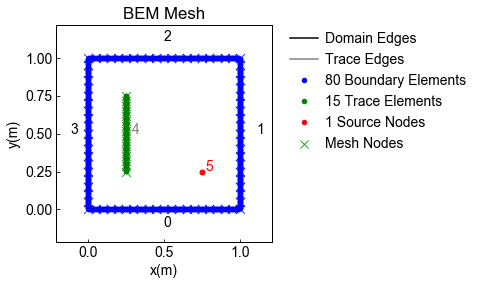

In [2]:
BEM_Case1=BEMpy.BEM2D()

#1.Build Mesh-#Anti-clock wise for internal domain
Boundary_vert=[(0.0, 0.0), (1.0, 0.0),(1.0,1.0),(0.0,1.0)] 

Trace_vert=[((0.25, 0.25), (0.25, 0.75))]

Source_vert=[(0.75,0.25)]

element_esize=1/20 #Edge mesh is important to overall mass balance
element_tszie=element_esize/1.5 #Trace mesh size

BEM_Case1.set_Mesh(Boundary_vert,Trace_vert,Source_vert,element_esize,element_tszie,Type="Quad")

#2.Set Boundary condition
bc0=[(0,0)]
BEM_Case1.set_BoundaryCondition(DirichletBC=bc0)

import numpy as np
def NeumannBC_func(Pts):
    #https://www.chegg.com/homework-help/questions-and-answers/2-solve-2d-steady-state-heat-conduction-equation-0-square-region-0-sx-s-1-0-sy-conditions--q24440992
    x,y=Pts[0],Pts[1]
    return 60*np.cos(4*np.pi*x)

bc_func=[(2,NeumannBC_func)]
BEM_Case1.set_BoundaryCondition(NeumannBC=bc_func,mode='func',update=1)

bc_sources=[(4,-5),(5,3)]
#bc_sources=[(4,-5)]
#bc_sources=[]
BEM_Case1.set_BoundaryCondition(DirichletBC=bc_sources,update=1)


#3.Set Domain Properties - permeability tensor
BEM_Case1.SetProps(k=3,miu=2)

#Check Mesh
BEM_Case1.plot_Mesh()
#Check Node,BC if necessary
#BEM_Case1.Mesh.print_debug()

In [3]:
import scipy

def serial_CPU_numpy(A,b,runs=10):
    for i in range(runs):
        X = np.linalg.solve(Ab[0], Ab[1])
    return X

def serial_CPU_scipy(A,b,runs=10):
    for i in range(runs):
        X = scipy.linalg.solve(Ab[0], Ab[1])
    return X

def serial_CPU_LU_scipy(A,b,runs=10): #Winnder
    LU,piv = scipy.linalg.lu_factor(A)
    for i in range(runs):
        X = scipy.linalg.lu_solve((LU,piv),b)
    return X

import torch
torch.set_default_dtype(torch.float64)

def serial_CPU_magma(A,b,runs=10):
    A_magma=torch.from_numpy(A)
    b_magma=torch.from_numpy(b).reshape([len(Ab[1]),1])
    for i in range(runs):
        X,_ = torch.solve(b_magma,A_magma)
    
    return X

def serial_GPU_magma(A,b,runs=10):
    A_magma=torch.from_numpy(A)
    b_magma=torch.from_numpy(b).reshape([len(Ab[1]),1])
    
    A_GPU=A_magma.cuda()
    b_GPU=b_magma.cuda()
    for i in range(runs):
        X,_ = torch.solve(b_GPU,A_GPU)
    return X.cpu()

def serial_CPU_LU_magma(A,b,runs=10):
    A_magma=torch.from_numpy(A)
    b_magma=torch.from_numpy(b).reshape([len(Ab[1]),1])
    
    LU,piv = torch.lu(A_magma)
    for i in range(runs):
        X = torch.lu_solve(b_magma, LU, piv)
    return X

def convert2Batch(A,b,runs=10):
    m,n=A.shape
    A_batch=np.zeros([runs,m,n])
    b_batch=np.zeros([runs,m,1])
    #print(A_batch.shape,b_batch.shape)
    for i in range(runs):
        A_batch[i,:,:]=A
        b_batch[i,:,0]=b
    A_batch=np.array(A_batch)
    b_batch=np.array(b_batch)
    #print(A_batch.shape,b_batch.shape)
    A_batch_magma=torch.from_numpy(A_batch)
    LU_batch,piv_batch = torch.lu(A_batch_magma)
    
    return A_batch,b_batch,np.array(LU_batch),np.array(piv_batch)

def batch_CPU_magma(A_batch,b_batch):
    #print(A_batch.shape,b_batch.shape)
    
    A_magma=torch.from_numpy(A_batch)
    b_magma=torch.from_numpy(b_batch)
    
    #print(A_magma,b_magma[:,0])
    X,_ = torch.solve(b_magma,A_magma)
    #print(X.shape)
    return X[0,:,:].flatten()


def batch_GPU_magma(A_batch,b_batch):    
    A_magma=torch.from_numpy(A_batch)
    b_magma=torch.from_numpy(b_batch)
    
    A_GPU=A_magma.cuda()
    b_GPU=b_magma.cuda()
    
    #print(A_magma,b_magma[:,0])
    X,_ = torch.solve(b_GPU,A_GPU)
    #print(X.shape)
    return X[0,:,:].flatten().cpu()

def batch_CPU_LU_magma(LU_batch,piv_batch,b_batch):
    #print(A_batch.shape,b_batch.shape)
    
    LU=torch.from_numpy(LU_batch)
    piv=torch.from_numpy(piv_batch)
    b_magma=torch.from_numpy(b_batch)
        
    X = torch.lu_solve(b_magma, LU, piv)
    return X[0,:,:].flatten()

def batch_GPU_LU_magma(LU_batch,piv_batch,b_batch):
    #print(A_batch.shape,b_batch.shape)
    
    LU=torch.from_numpy(LU_batch).cuda()
    piv=torch.from_numpy(piv_batch).cuda()
    b_magma=torch.from_numpy(b_batch).cuda()
        
    X = torch.lu_solve(b_magma, LU, piv)
    return X[0,:,:].flatten()
    
#Set single thread 
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import mkl
mkl.set_num_threads(1)

10

In [21]:
from multiprocessing import Pool
pool=Pool()


Ab=BEM_Case1.AssembleMatrix()
runs=10000
LU_piv = scipy.linalg.lu_factor(Ab[0])
LU_pivs=[LU_piv]*runs
bs=[Ab[1]]*runs

def parallel_CPU_LU_scipy(A,b,runs=10): #Winnder
    #https://stackoverflow.com/questions/5442910/python-multiprocessing-pool-map-for-multiple-arguments
    LU_piv = scipy.linalg.lu_factor(A)

    #LU_pivs=[LU_piv]*runs
    #bs=[b]*runs
    X=pool.starmap(scipy.linalg.lu_solve, zip(LU_pivs, bs))   
    return X[0]

[Solution] #DOFs= 286


In [22]:
import time

Ab=BEM_Case1.AssembleMatrix()

start = time.time()
X=serial_CPU_numpy(Ab[0],Ab[1],runs=10000)
end = time.time()
RunTime_numpy=end - start
print('Numpy RunTime=%e'%(end - start))

[Solution] #DOFs= 286
Numpy RunTime=4.626724e+00


In [23]:
start = time.time()
X=serial_CPU_scipy(Ab[0],Ab[1],runs=10000)
end = time.time()
RunTime_scipy=end - start
print('Scipy RunTime=%e'%(end - start))

Scipy RunTime=7.163068e+00


In [26]:
start = time.time()
X=serial_CPU_LU_scipy(Ab[0],Ab[1],runs=10000)
end = time.time()
RunTime_scipy_LU=end - start
print('Scipy LU RunTime=%e'%(end - start))

Scipy LU RunTime=2.310004e-01


In [38]:
start = time.time()
X=parallel_CPU_LU_scipy(Ab[0],Ab[1],runs=10000)
end = time.time()
RunTime_scipy_LU_p=end - start
print('Scipy Parallel LU RunTime=%e'%(end - start))

Scipy Parallel LU RunTime=7.625175e-02


In [39]:
RunTime_numpy/RunTime_scipy_LU

20.02907359586164

In [40]:
RunTime_numpy/RunTime_scipy_LU_p

60.67696507130506

In [41]:
RunTime_scipy_LU/RunTime_scipy_LU_p

3.029444411440078

In [42]:
RunTime_scipy/RunTime_scipy_LU

31.008894751291688

In [58]:
start = time.time()
X=serial_CPU_magma(Ab[0],Ab[1],runs=10000)
end = time.time()
RunTime_magma=end - start
print('Mamga CPU RunTime=%e'%(end - start))

Mamga CPU RunTime=1.944956e+00


In [59]:
start = time.time()
X=serial_CPU_LU_magma(Ab[0],Ab[1],runs=10000)
end = time.time()
RunTime_magma_LU=end - start
print('Mamga LU RunTime=%e'%(end - start))

Mamga LU RunTime=2.449598e-01


In [10]:
torch.cuda.synchronize()
start = time.time()
X=serial_GPU_magma(Ab[0],Ab[1],runs=1000)
torch.cuda.synchronize()
end = time.time()
RunTime_magma=end - start
print('Mamga GPU RunTime=%e'%(end - start))
torch.cuda.empty_cache()

Mamga GPU RunTime=4.495000e+00


In [11]:
A_batch,b_batch=convert2Batch(Ab[0],Ab[1],runs=10000)

torch.cuda.synchronize()
start = time.time()
X=batch_CPU_magma(A_batch,b_batch)
torch.cuda.synchronize()
end = time.time()
RunTime_magma=end - start
print('Mamga Batch CPU RunTime=%e'%(end - start))

Mamga Batch CPU RunTime=1.548999e+00


In [14]:
A_batch,b_batch=convert2Batch(Ab[0],Ab[1],runs=10000)

torch.cuda.synchronize()
start = time.time()
X=batch_GPU_magma(A_batch,b_batch)
torch.cuda.synchronize()
end = time.time()
RunTime_magma=end - start
print('Mamga Batch GPU RunTime=%e'%(end - start))
torch.cuda.empty_cache()

Mamga Batch GPU RunTime=8.149459e-01


In [45]:
A_batch,b_batch,LU_batch,piv_batch=convert2Batch(Ab[0],Ab[1],runs=10000)

torch.cuda.synchronize()
start = time.time()
X=batch_CPU_LU_magma(LU_batch,piv_batch,b_batch)
torch.cuda.synchronize()
end = time.time()
RunTime_magma=end - start
print('Mamga Batch CPU LU RunTime=%e'%(end - start))
torch.cuda.empty_cache()

Mamga Batch CPU LU RunTime=7.110004e-01


In [47]:
A_batch,b_batch,LU_batch,piv_batch=convert2Batch(Ab[0],Ab[1],runs=10000)

torch.cuda.synchronize()
start = time.time()
X=batch_GPU_LU_magma(LU_batch,piv_batch,b_batch)
torch.cuda.synchronize()
end = time.time()
RunTime_magma=end - start
print('Mamga Batch GPU LU RunTime=%e'%(end - start))
torch.cuda.empty_cache()

Mamga Batch GPU LU RunTime=1.027001e+00


[Visulization] Plotting Solution


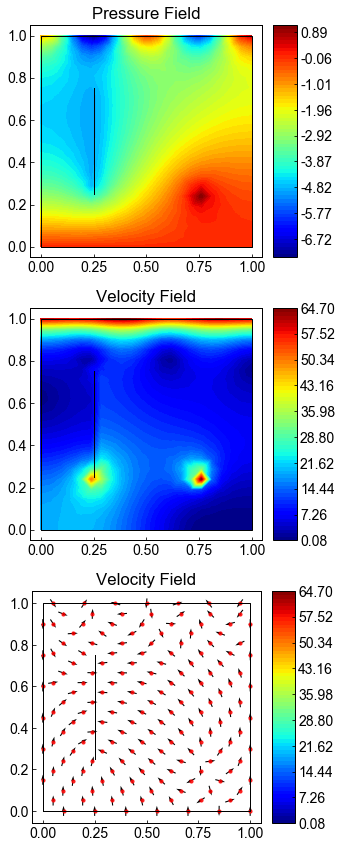

In [37]:
BEM_Case1.ApplySolution(X)
xx=BEM_Case1.PostProcess.plot_Solution()